In [139]:
import math
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read Datasets

In [114]:
# Load the dataset and check the first 5 records

df = pd.read_csv("data/bestsellers with categories.csv", encoding='ISO-8859-1')
df.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


In [115]:
# List the columns in the dataframe
print(df.columns)
print(f"total colums: {len(df.columns)}")
print(f"total records: {len(df)}")

Index(['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre'], dtype='object')
total colums: 7
total records: 550


In [116]:
# Check if the columns contain Null values
df.isna().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

## Cleaning

### Renaming Columns

In [117]:
# Column names in the original dataset contains spaces which are not easier to
# work with. So, we will replace spaces with "_" and make the names lowercase.

new_names = {}

for old_name in df.columns:
    new_names[old_name] = old_name.lower().replace(" ", "_")

df = df.rename(columns=new_names)
df.columns

Index(['name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre'], dtype='object')

### Dtype Checking

In [118]:
# What variables are of decimal/float datatype?
float_cols = []

for col in df:
    if df[col].dtype == np.float64:
        float_cols.append(col)

print(len(float_cols))
print(float_cols)

1
['user_rating']


In [119]:
# What variables are of integer datatype?
int_cols = []

for col in df:
    if df[col].dtype == np.int64:
        int_cols.append(col)

print(len(int_cols))
print(int_cols)

3
['reviews', 'price', 'year']


In [120]:
# What variables are of string/object/categorical datatype?
str_cols = []

for col in df:
    if df[col].dtype == "object":
        str_cols.append(col)

print(len(str_cols))
print(str_cols)

3
['name', 'author', 'genre']


### Genre

In [121]:
fiction = len(df[df.genre == 'Fiction'])
non_fiction = len(df[df.genre == 'Non Fiction'])

print(f"num of fiction books: {fiction}")
print(f"num of non fiction books: {non_fiction}")
print(f"ratio: {fiction / non_fiction}")

num of fiction books: 240
num of non fiction books: 310
ratio: 0.7741935483870968


The ratio of the number of fiction and non-fiction books is 77% so we can say that the dataset is somewhat balanced.

### Rating

In [122]:
print(f"min: {df['user_rating'].min()}")
print(f"max: {df['user_rating'].max()}")

print(f"mean: {df['user_rating'].mean()}")
print(f"std: {df['user_rating'].std()}")

min: 3.3
max: 4.9
mean: 4.618363636363637
std: 0.2269803650251963


## General Funcs

In [123]:
def get_stats(series, name, cdf=True, reset_index=True):
    
    '''
    Calculate frequency, pmf and cdf of the values in the variable.
    Args:
        series (Pandas.Series): The variable column
        name (String): Name of the variable column
        cdf (Boolean): To calculate cdf or not
        reset_index (Boolean): to reset the index of the resulting series or not
    Returns:
        Pandas.DataFrame
    '''
    
    df = pd.DataFrame(series)
    stats_df = df.groupby(name)[name] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {name: 'frequency'})

    stats_df['pmf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    if cdf:
        stats_df['cdf'] = stats_df['pmf'].cumsum()

    if reset_index:
        stats_df = stats_df.reset_index()

    return stats_df

## Effect Size
Let's pose a question. Does bestselling fiction books get higher user rating than bestselling nonfiction books?
To answer that question, we will first plot user rating distributions of fiction books and user rating distribution of nonfiction books.   
And then we will measure the difference between those two distributions.   
Effect size is the size of the difference between those two distributions.

In [124]:
fiction_df = df[df.genre=="Fiction"]
nonfiction_df = df[df.genre=="Non Fiction"]

print(len(fiction_df))
print(len(nonfiction_df))

240
310


<Axes: xlabel='user_rating'>

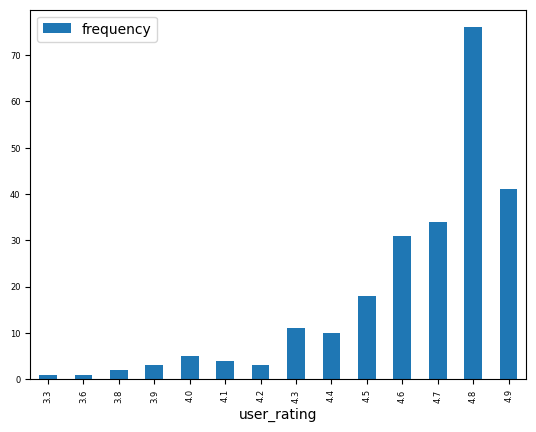

In [125]:
rating_stats = get_stats(fiction_df.user_rating, "user_rating", cdf=False, reset_index=True)
rating_stats.plot.bar(x="user_rating", y="frequency", rot=90.0, fontsize=6)

Fiction books get lots of 4.8 ratings followed by 4.9 ratings as second highest.

<Axes: xlabel='user_rating'>

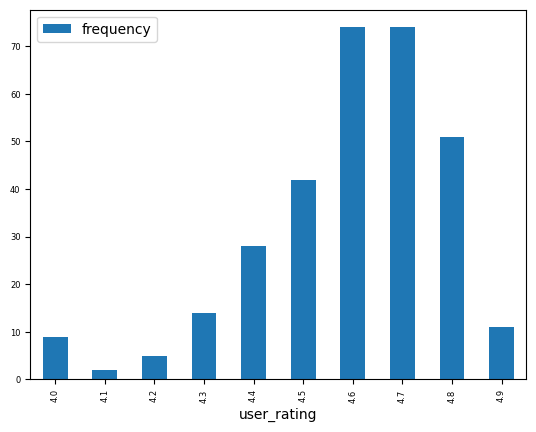

In [126]:
rating_stats = get_stats(nonfiction_df.user_rating, "user_rating", cdf=False, reset_index=True)
rating_stats.plot.bar(x="user_rating", y="frequency", rot=90.0, fontsize=6)

Non-fiction books gets lots of 4.6 and 4.7 ratings with 4.8 as second highest rating.

Now let's compare the mean rating of fiction books and mean rating of non-fiction books to see whether fiction books or non-fiction books get higher average rating.

In [127]:
print(f"mean of fiction rating: {fiction_df['user_rating'].mean()}")
print(f"mean of nonfiction rating: {nonfiction_df['user_rating'].mean()}")

mean of fiction rating: 4.6483333333333325
mean of nonfiction rating: 4.59516129032258


Mean value says that average rating of fiction books is marginally higher than that of non-fiction books. We have to see whether that effect size is significant or not.

### Cohen's Difference

Cohen's difference is one way to measure the effect size or standardized difference between means of two distributions.    
Cohen's d of 0.01 is considered to be very small with 0.2 as small, 0.5 as medium, 0.8 as large, 1.2 as very large and 2.0 as huge.   
Now let's measure Cohen's d between fiction and non-fiction ratings.

In [128]:
def cohen_diff(group1, group2):
  diff = group1.mean() - group2.mean()

  var1 = group1.var()
  var2 = group2.var()
  n1 = len(group1)
  n2 = len(group2)

  pooled_var = (n1 * var1 + n2 * var2) / (n1+n2)
  d = diff / math.sqrt(pooled_var)

  return d

In [129]:
print(f"cohen diff: {cohen_diff(fiction_df.user_rating, nonfiction_df.user_rating)}")

cohen diff: 0.235624987190022


Cohen's d between fiction and non-fiction ratings is 0.236 which can be considered as small. So we can say that the rating difference is not so significant.    
Now let's see whether the effect size is significant under the good old famous "hypothesis testing".

## Hypothesis Testing

What is hypothesis testing? What does it test?    
Objective of a hypothesis testing is to answer the question "Given a sample and an effect, what is the probability that the effect occurs by chance?"     
       
The steps to carry out hypothesis testing is:
1. Define the test statistics to measure the effect size. In this example, test statistics is the cohen's d between fiction and non-fiction ratings.
2. Define the null hypothesis which is the hypothesis under which the effect is not real. In this example, null hypothesis is that there is no difference in user rating between fiction and non-fiction books and they come from same distribution.
3. Define p-value which is the probability of seeing the effect under null hypothesis. In this example, p-value will be the probability of seeing the cohen's d value greater than 0.236 under null hypothesis.    
    
If the p-value is lower enough, commonly under 0.05, the effect is said to be statistically significant and considered it cannot occur by chance.

In [151]:
class HypothesisTest:
    '''Abstract Class for hypothesis testing'''
    def __init__(self, data):
        self.data = data
        self.actual_effect = self.test_statistics(data)
        
    def test_statistics(self, data):
        '''Test statistics to measure the effect size'''
        raise NotImplementedError
    
    def null_hypothesis(self):
        '''Sampling distribution under null hypothesis'''
        raise NotImplementedError
    
    def p_value(self, iter=1000):
        '''Calculate p-value'''
        null_effects = [self.test_statistics(self.null_hypothesis())
                           for _ in range(iter)]
        count = sum([1 for x in null_effects if x >= self.actual_effect])
        return count / iter

In [158]:
class RatingTest(HypothesisTest):
    def test_statistics(self, data):
        fiction_rating, nonfiction_rating = data
        return fiction_rating.mean() - nonfiction_rating.mean()
    
    def null_hypothesis(self):
        fiction_rating, nonfiction_rating = self.data
        n = len(fiction_rating)
        pool = np.hstack((fiction_rating, nonfiction_rating))
        np.random.shuffle(pool)
        data = (pool[:n], pool[n:])
        return data

In [159]:
rating_test = RatingTest((fiction_df.user_rating.values, nonfiction_df.user_rating.values))

p_values = []

for _ in range(1000):
    p_values.append(rating_test.p_value())
    
statistics.mean(p_values)

0.00302

The test statistics we used here is the one-sided difference in mean of fiction and non-fiction ratings. We used one-sided difference because we want to answer the question whether the fiction rating is higher than non-fiction rating.    
Null hypothesis is defined by shuffling the fiction and non-fiction rating values and reassigned which is to simulate the scenerio where there is no difference between fiction and non-fiction ratings.   
After running the test for 1000 times, we can see that the p-value is 0.003 which is less than 1%. We can say that it is not possible for this effect to occur by chance and it is statistically significant.